# Challenge 3

This challenge is about deriving metrics for tipping points. Asking the question "can we identify a tipping point before it happens".
There are established methods we can draw on for this that focus on qualities of the timeseries on the lead upto an event. These methods use ideas of variance and autocorrelation.

## Find a timeseries
The process begins with extracting a timeseries from the model data.

In [1]:
import xarray as xr # xarray for accessing and manipulating data
import numpy as np # numpy works with unlabelled arrays

We are going focus on surface temperature data.

In [2]:
path = "/gws/pw/j07/workshop/ARIA_src_data/"
t_path = path + "VERIFY_eORCA025_MED_UKESM_19900101_20710101_grid_T.nc"

In [3]:
tos = xr.open_dataset(t_path).tos # get surface temperature data

In [4]:
# Extract a time series but choosing a latitutde and longitude you want to investigate, for eg. latitude = 70N, longitude= 10E: 
target_lat = 70
target_lon = 10

# Then find the closest model point to these coordinates 
dist = ((tos.nav_lat - target_lat)**2 + (tos.nav_lon - target_lon)**2)**0.5

# Find the index of the closest point by: 
dist_1d = dist.stack(points=("y", "x")) # Turning the 2D grid (y, x) into a 1D list of points called "points". Each entry in "points" corresponds to the a set of (y, x).
ip = dist_1d.argmin("points") # getting index of the point with minimum distance (closest point) 

# Recover the original (y, x) indices from the stacked MultiIndex
j = dist_1d["y"].isel(points=ip).item()
i = dist_1d["x"].isel(points=ip).item()

tos_timeseries = tos.isel(x=i,y=j)

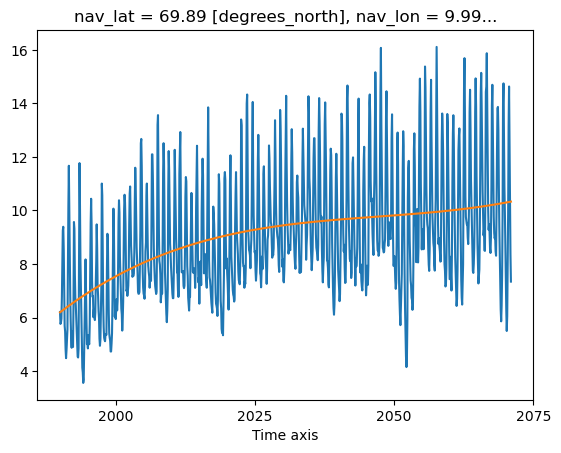

In [5]:
# This function is designed to remove the trend from the timeseries
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit, fit

# detrended_tos is the detrended temperature timeseries and fit defined the fitted curve
detrended_tos, fit = detrend_dim(tos_timeseries, "time_counter", 3)

# we can show the fit here
tos_timeseries.plot()
fit.plot()

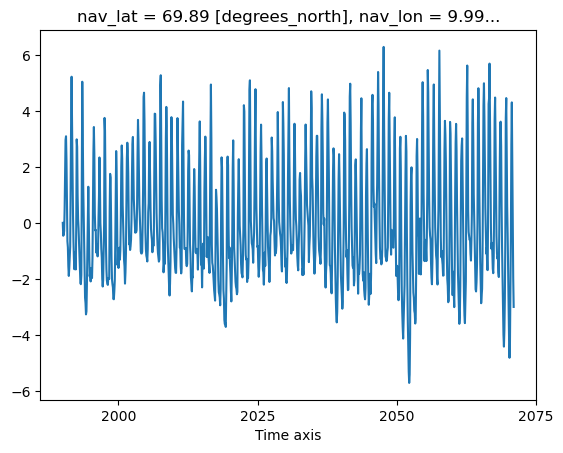

In [6]:
# once detrended, we recover temporal variability
detrended_tos.plot()

## Variance
Inceases in variance is one way of identifying a potential tipping point

In [7]:
# let's calcualte variance over a rolling window
tos_variance = detrended_tos.rolling(time_counter=120).var()

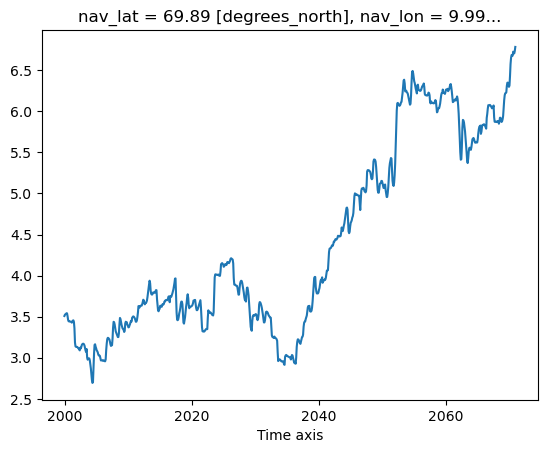

In [8]:
# We then plot the variance to evaluate the emergence of a tipping point in this system
tos_variance.plot()

In [9]:
# are we heading for a tipping point???

# Auto correlation
An alternative predictor of a tipping point can be the lag 1 autocorrelation.
This means the correlation of the timeseries with itself at a lag interval of 1 timestep

In [10]:
ww = 120 # window size 
roll = detrended_tos.rolling(time_counter=ww).construct("window") # build a rolling object with 'window' dimension

x1 = roll.isel(window=slice(0, -1)) # first window 'series' 
x2 = roll.isel(window=slice(1, None)) # shifted series to correlate

# Skip the first few positions. Are there 0, nans, or not enough values?? 
x1 = x1.isel(time_counter=slice(120, None))
x2 = x2.isel(time_counter=slice(120, None)) 


rac1 = xr.corr(x2, x1, dim="window") # autocorrelation for each running window


<xarray.DataArray (time_counter: 972, window: 120)> Size: 933kB
array([[        nan,         nan,         nan, ...,         nan,
                nan,  0.01341849],
       [        nan,         nan,         nan, ...,         nan,
         0.01341849, -0.44741911],
       [        nan,         nan,         nan, ...,  0.01341849,
        -0.44741911, -0.41308853],
       ...,
       [-0.67885154, -1.74616877, -2.32266358, ...,  4.31293969,
         2.08961498, -0.12001605],
       [-1.74616877, -2.32266358, -2.90617834, ...,  2.08961498,
        -0.12001605, -1.94730301],
       [-2.32266358, -2.90617834, -3.5904135 , ..., -0.12001605,
        -1.94730301, -2.98709555]], shape=(972, 120))
Coordinates:
    nav_lat        float32 4B 69.89
    nav_lon        float32 4B 9.999
    time_centered  (time_counter) object 8kB 1990-01-16 00:00:00 ... 2070-12-...
  * time_counter   (time_counter) object 8kB 1990-01-16 00:00:00 ... 2070-12-...
Dimensions without coordinates: window

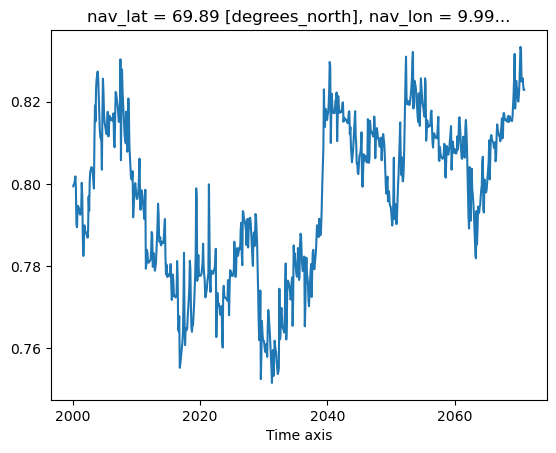

In [11]:
rac1.plot()
roll

In [12]:
# by this measure, our imminent tipping point is less convincing